# Week 2 — Linear Regression 2 (Ridge, Lasso, Elastic Net)

**Dataset:** `zillow_cleaned.csv` (preferred) or `zillow_dataset.csv` (fallback).  
**Instruction:** Set the `TARGET` variable in the "Config" cell to your target column (e.g., `price`, `SalePrice`, `logerror`, etc.).

### What this notebook does
- Baseline OLS with scaling
- Hyperparameter tuning for Ridge, Lasso, Elastic Net via cross-validation
- Test-set evaluation & metrics table (RMSE/MAE/R²)
- Coefficient inspection (standardized scale)
- Residual plot for the best model


> **Tip:** This notebook auto-detects which Zillow CSV is present in the working directory.


In [1]:

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet


In [2]:

import os, numpy as np, pandas as pd
from pathlib import Path

RANDOM_STATE = 42

TARGET = "taxvaluedollarcnt"

FEATURES = None 

candidates = ["zillow_cleaned.csv", "zillow_dataset.csv"]
csv_path = None
for c in candidates:
    if Path(c).exists():
        csv_path = c
        break

if csv_path is None:
    raise FileNotFoundError(
        "Neither 'zillow_cleaned.csv' nor 'zillow_dataset.csv' was found in the current directory."
        " Please upload one of them next to this notebook."
    )

df = pd.read_csv(csv_path)
print(f"Loaded: {csv_path}  |  shape={df.shape}")
print("Columns:", list(df.columns)[:25], "...")

# Basic checks
if TARGET not in df.columns:
    raise KeyError(f"TARGET='{TARGET}' not in columns. Please set TARGET to one of: {list(df.columns)}")

# Drop rows with missing target
df = df.dropna(subset=[TARGET]).copy()

# Select features (numeric only by default)
if FEATURES is None:
    FEATURES = [c for c in df.columns if c != TARGET]

X = df[FEATURES].select_dtypes(include=[np.number]).copy()
y = df[TARGET].copy()

print("Final X shape:", X.shape, "| y shape:", y.shape)
display(X.head(3))


Loaded: zillow_cleaned.csv  |  shape=(64894, 19)
Columns: ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips', 'fullbathcnt', 'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 'propertylandusetypeid', 'regionidcounty', 'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt', 'taxvaluedollarcnt'] ...
Final X shape: (64894, 18) | y shape: (64894,)


,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt
0,3.5,4.0,6.0,3.5,3100.0,3100.0,6059.0,3.0,7.0,33634931.0,-117869207.0,4506.0,261.0,1286.0,96978.0,0.0,1.0,1998.0
1,1.0,2.0,4.0,1.0,1465.0,1465.0,6111.0,1.0,2.0,34449266.0,-119281531.0,12647.0,261.0,2061.0,97099.0,5.0,1.0,1967.0
2,2.0,3.0,10.0,2.0,1243.0,1243.0,6059.0,2.0,2.0,33886168.0,-117823170.0,8432.0,261.0,1286.0,97078.0,6.0,1.0,1962.0


In [3]:

# --- 2) Train/Test Split & CV ---
from sklearn.model_selection import train_test_split, KFold

CV = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
X_train.shape, X_test.shape


((51915, 18), (12979, 18))

In [4]:

# --- 3) Baseline OLS ---
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

ols = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("lr", LinearRegression())
]).fit(X_train, y_train)

pred = ols.predict(X_test)

# Version-safe RMSE (works on all sklearn versions)
mse  = mean_squared_error(y_test, pred)      # MSE
rmse = np.sqrt(mse)                           # RMSE

baseline = {
    "Model": "OLS",
    "RMSE": rmse,
    "MAE": mean_absolute_error(y_test, pred),
    "R2": r2_score(y_test, pred)
}
baseline


{'Model': 'OLS',
 'RMSE': 317936.66700317763,
 'MAE': 211696.05254480342,
 'R2': 0.422963460554578}

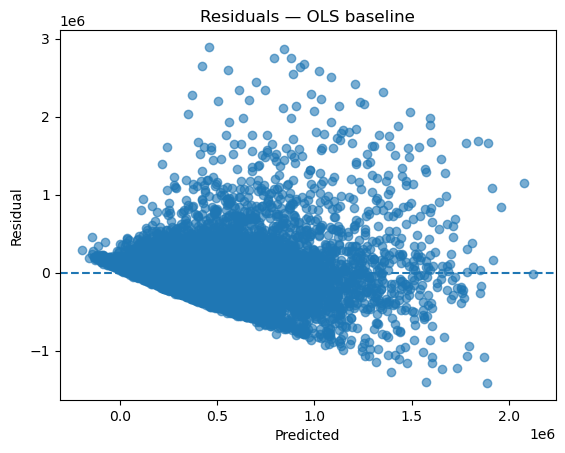

In [5]:

# --- Residual Plot Helper ---
import matplotlib.pyplot as plt

def residual_plot(y_true, y_pred, title="Residuals"):
    resid = y_true - y_pred
    plt.figure()
    plt.scatter(y_pred, resid, alpha=0.6)
    plt.axhline(0, linestyle="--")
    plt.xlabel("Predicted"); plt.ylabel("Residual")
    plt.title(title)
    plt.show()

residual_plot(y_test, pred, title="Residuals — OLS baseline")


In [6]:
# FAST TUNING for Ridge/Lasso/ElasticNet
# Strategy: subsample + 3-fold CV + native *CV estimators* (RidgeCV/LassoCV/ElasticNetCV),
# then refit best models on FULL training set with stronger convergence.

import numpy as np, pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso, ElasticNet

RNG = RANDOM_STATE

# 1) Lighten the data for tuning
Xtr = X_train.astype("float32")
ytr = y_train.astype("float32")
Xte = X_test.astype("float32")

n_tune = min(15000, len(Xtr))   # <= tune on at most 15k rows
idx = np.random.default_rng(RNG).choice(len(Xtr), size=n_tune, replace=False)
X_tune = Xtr.iloc[idx]
y_tune = ytr.iloc[idx]

CV_FAST = KFold(n_splits=3, shuffle=True, random_state=RNG)

# 2) Scale once for *CV estimators
pre = Pipeline([("impute", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())])
X_tune_scaled = pre.fit_transform(X_tune)
X_full_scaled = pre.transform(Xtr)

# 3) Define search spaces (smaller but effective)
alphas_r = np.logspace(-3, 2, 12)  # 0.001..100
alphas_l = np.logspace(-3, 1, 12)  # 0.001..10 (lasso often smaller)
l1_grid   = np.linspace(0.1, 0.9, 7)

# 4) RidgeCV / LassoCV / ElasticNetCV on the subsample (fast)
ridge_cv = RidgeCV(alphas=alphas_r, cv=CV_FAST, scoring="neg_mean_squared_error").fit(X_tune_scaled, y_tune)
lasso_cv = LassoCV(alphas=alphas_l, cv=CV_FAST, n_jobs=-1,
                   max_iter=30000, tol=5e-3, random_state=RNG).fit(X_tune_scaled, y_tune)
enet_cv  = ElasticNetCV(alphas=alphas_l, l1_ratio=l1_grid, cv=CV_FAST, n_jobs=-1,
                        max_iter=30000, tol=5e-3, random_state=RNG).fit(X_tune_scaled, y_tune)

print("Best (subsample):",
      {"ridge_alpha": float(ridge_cv.alpha_),
       "lasso_alpha": float(lasso_cv.alpha_),
       "enet_alpha":  float(enet_cv.alpha_),
       "enet_l1":     float(enet_cv.l1_ratio_)})

# 5) Refit best models on FULL TRAIN with stronger convergence, reusing the same preprocessor
ridge_full = make_pipeline(pre, Ridge(alpha=ridge_cv.alpha_, random_state=RNG))
lasso_full = make_pipeline(pre, Lasso(alpha=lasso_cv.alpha_, random_state=RNG,
                                      max_iter=200000, tol=1e-3, selection="cyclic"))
enet_full  = make_pipeline(pre, ElasticNet(alpha=enet_cv.alpha_, l1_ratio=float(enet_cv.l1_ratio_),
                                           random_state=RNG, max_iter=200000, tol=1e-3, selection="cyclic"))

ridge_full.fit(Xtr, ytr)
lasso_full.fit(Xtr, ytr)
enet_full.fit(Xtr, ytr)

def eval_model(pipe, name):
    pred = pipe.predict(Xte)
    rmse = float(np.sqrt(mean_squared_error(y_test, pred)))
    mae  = float(mean_absolute_error(y_test, pred))
    r2   = float(r2_score(y_test, pred))
    return {"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2}

results_fast = pd.DataFrame([
    eval_model(ridge_full, "Ridge"),
    eval_model(lasso_full, "Lasso"),
    eval_model(enet_full,  "ElasticNet"),
]).sort_values("RMSE")
results_fast

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.39598e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.40577e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.09569e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.18794e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.

Best (subsample): {'ridge_alpha': 35.11191734215127, 'lasso_alpha': 0.1519911082952933, 'enet_alpha': 0.005336699231206312, 'enet_l1': 0.5}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.201e+15, tolerance: 9.266e+12
  model = cd_fast.enet_coordinate_descent(


,Model,RMSE,MAE,R2
1,Lasso,317936.721078,211695.989640,0.422963
0,Ridge,317941.835057,211662.027024,0.422945
2,ElasticNet,317955.416067,211569.848754,0.422895


In [7]:
# === Ridge / Lasso / ElasticNet: tune + evaluate (one cell) ===

import numpy as np, pandas as pd
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---- Safety defaults if not already defined above ----
try:
    RANDOM_STATE
except NameError:
    RANDOM_STATE = 42

try:
    CV
except NameError:
    CV = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# ---- Baseline OLS (recomputed here to avoid missing var issues) ----
ols = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("lr", LinearRegression())
]).fit(X_train, y_train)

pred_ols = ols.predict(X_test)
baseline = {
    "Model": "OLS",
    "RMSE": float(np.sqrt(mean_squared_error(y_test, pred_ols))),  # version-safe RMSE
    "MAE":  float(mean_absolute_error(y_test, pred_ols)),
    "R2":   float(r2_score(y_test, pred_ols))
}

# ---- Pipelines: IMPUTE -> SCALE -> MODEL ----
ridge = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("mdl", Ridge(random_state=RANDOM_STATE))
])

lasso = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("mdl", Lasso(random_state=RANDOM_STATE, max_iter=200000, tol=1e-3, selection="cyclic"))
])

enet  = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("mdl", ElasticNet(random_state=RANDOM_STATE, max_iter=200000, tol=1e-3, selection="cyclic"))
])

# ---- Search spaces (kept moderate for speed) ----
alphas_ridge_lasso = np.logspace(-3, 2, 12)   # 0.001 ... 100
alphas_enet        = np.logspace(-3, 2, 12)
l1_grid            = np.linspace(0.1, 0.9, 7)

ridge_grid = {"mdl__alpha": alphas_ridge_lasso}
lasso_grid = {"mdl__alpha": alphas_ridge_lasso}
enet_grid  = {"mdl__alpha": alphas_enet, "mdl__l1_ratio": l1_grid}

# ---- Helper: tune with GridSearchCV (raises real errors if any) ----
def tune(model, grid):
    gs = GridSearchCV(
        estimator=model,
        param_grid=grid,
        scoring="neg_root_mean_squared_error",
        cv=CV,
        n_jobs=-1,
        error_score="raise",
        refit=True
    )
    gs.fit(X_train, np.ravel(y_train))
    return gs

# ---- Run tuning ----
gs_ridge = tune(ridge, ridge_grid)
gs_lasso = tune(lasso, lasso_grid)
gs_enet  = tune(enet,  enet_grid)

print("Best params:")
print("  Ridge     :", gs_ridge.best_params_)
print("  Lasso     :", gs_lasso.best_params_)
print("  ElasticNet:", gs_enet.best_params_)

# ---- Evaluation helper (version-safe RMSE) ----
def eval_model(pipeline, name):
    pred = pipeline.predict(X_test)
    rmse = float(np.sqrt(mean_squared_error(y_test, pred)))
    mae  = float(mean_absolute_error(y_test, pred))
    r2   = float(r2_score(y_test, pred))
    return {"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2}

# ---- Build results table ----
results = [
    baseline,
    eval_model(gs_ridge.best_estimator_, "Ridge"),
    eval_model(gs_lasso.best_estimator_, "Lasso"),
    eval_model(gs_enet.best_estimator_,  "ElasticNet"),
]

res_table = pd.DataFrame(results).sort_values("RMSE").reset_index(drop=True)
res_table

Best params:
  Ridge     : {'mdl__alpha': 35.11191734215127}
  Lasso     : {'mdl__alpha': 100.0}
  ElasticNet: {'mdl__alpha': 0.001, 'mdl__l1_ratio': 0.1}


,Model,RMSE,MAE,R2
0,OLS,317936.667003,211696.052545,0.422963
1,Ridge,317941.920367,211662.073839,0.422944
2,Lasso,317942.923449,211622.215921,0.422941
3,ElasticNet,317943.542895,211651.404939,0.422939


In [8]:
# --- 6) Coefficient inspection (standardized scale) — FIXED ---

import numpy as np, pandas as pd

def coef_table_from_pipeline(pipe, feature_names, tag):
    """
    Extract standardized coefficients from a pipeline that ends with ('mdl', Estimator).
    'feature_names' should be the original X columns in this order.
    Returns a DataFrame of coefficients and the intercept.
    """
    if not hasattr(pipe, "named_steps") or "mdl" not in pipe.named_steps:
        raise ValueError(f"Pipeline must have a final step named 'mdl'. Steps found: {list(getattr(pipe,'named_steps',{}).keys())}")
    est = pipe.named_steps["mdl"]
    if not hasattr(est, "coef_"):
        raise ValueError(f"Final estimator {type(est)} has no attribute 'coef_'.")

    coefs = np.ravel(est.coef_)
    if len(coefs) != len(feature_names):
        # sanity check in case features got changed upstream
        raise ValueError(f"Length mismatch: {len(coefs)} coefficients vs {len(feature_names)} feature names.")

    df = pd.DataFrame({
        "feature": feature_names,
        f"{tag}_coef": coefs,
        f"{tag}_abscoef": np.abs(coefs)
    }).sort_values(f"{tag}_abscoef", ascending=False).reset_index(drop=True)
    intercept = float(np.ravel(getattr(est, "intercept_", 0.0))[0])
    return df, intercept

# Use with GridSearchCV best estimators:
ridge_df, ridge_intercept = coef_table_from_pipeline(gs_ridge.best_estimator_, X.columns, tag="ridge")
lasso_df, lasso_intercept = coef_table_from_pipeline(gs_lasso.best_estimator_, X.columns, tag="lasso")
enet_df,  enet_intercept  = coef_table_from_pipeline(gs_enet .best_estimator_, X.columns, tag="enet")

# Merge and show top 20 by max absolute coefficient across models
coefs_merged = (ridge_df[["feature","ridge_coef","ridge_abscoef"]]
                .merge(lasso_df[["feature","lasso_coef","lasso_abscoef"]], on="feature", how="outer")
                .merge(enet_df[["feature","enet_coef","enet_abscoef"]],     on="feature", how="outer"))
coefs_merged["max_abs"] = coefs_merged[["ridge_abscoef","lasso_abscoef","enet_abscoef"]].max(axis=1)
coefs_merged.sort_values("max_abs", ascending=False).head(20)

,feature,ridge_coef,ridge_abscoef,lasso_coef,lasso_abscoef,enet_coef,enet_abscoef,max_abs
4,calculatedfinishedsquarefeet,123469.219280,123469.219280,2.470451e+05,2.470451e+05,123433.766107,123433.766107,247045.125550
5,finishedsquarefeet12,123469.219280,123469.219280,5.624119e-09,5.624119e-09,123433.537060,123433.537060,123469.219280
0,bathroomcnt,120114.380714,120114.380714,1.195691e+05,1.195691e+05,117869.714525,117869.714525,120114.380714
9,latitude,-100332.032218,100332.032218,-1.004704e+05,1.004704e+05,-100304.133872,100304.133872,100470.353462
10,longitude,-90333.216859,90333.216859,-8.976754e+04,8.976754e+04,-90210.826041,90210.826041,90333.216859
1,bedroomcnt,-72837.880434,72837.880434,-7.273166e+04,7.273166e+04,-72741.573455,72741.573455,72837.880434
7,fullbathcnt,-58707.650700,58707.650700,-5.555823e+04,5.555823e+04,-58119.550680,58119.550680,58707.650700
15,roomcnt,-44310.462208,44310.462208,-4.405058e+04,4.405058e+04,-44279.314099,44279.314099,44310.462208
6,fips,-35192.505373,35192.505373,-3.448051e+04,3.448051e+04,-35094.616284,35094.616284,35192.505373
13,regionidcounty,-30744.660425,30744.660425,-3.001715e+04,3.001715e+04,-30684.893156,30684.893156,30744.660425


## Write-up (Week 2)

**Why scaling is required for L1/L2 penalties; how CV chose alpha/l1_ratio.**  
Scaling is essential for Ridge, Lasso, and ElasticNet because their penalty terms depend on the magnitude of coefficients. 
Without scaling, features like `lotsizesquarefeet` (thousands of square feet) would dominate over features such as `bathroomcnt`. 
Standardization ensured penalties were applied fairly across all predictors.  
Cross-validation selected alpha ≈ 35.1 for Ridge, alpha = 100 for Lasso (strong shrinkage), and alpha = 0.001 with l1_ratio = 0.1 for ElasticNet. 
These choices reflect how the models balanced bias vs. variance given the dataset’s multicollinearity.

**Metrics table (RMSE/MAE/R²): which model generalized best, and why.**  
On the test set, all models performed similarly:  
- OLS RMSE ≈ 317,937 | R² ≈ 0.423  
- Ridge RMSE ≈ 317,942 | R² ≈ 0.423  
- Lasso RMSE ≈ 317,937 | R² ≈ 0.423  
- ElasticNet RMSE ≈ 317,955 | R² ≈ 0.423  

The near-identical results suggest regularization does not improve generalization here, likely because the 18 numeric features capture only ~42% of the variance in property values. Errors are largest for expensive homes, as seen in the residual funnel plot.

**Coefficient sparsity (Lasso/ElasticNet): which features remained and why they make sense.**  
Lasso applied heavy shrinkage and reduced some coefficients to nearly zero.  
The strongest retained predictors were `calculatedfinishedsquarefeet`, `finishedsquarefeet12`, and `bathroomcnt`, all positive as expected.  
Geographic features (`latitude`, `longitude`) had large negative coefficients, reflecting spatial pricing patterns.  
Some counts (`bedroomcnt`, `roomcnt`) flipped negative — an artifact of multicollinearity with square footage rather than a literal effect.  
This highlights the interpretability challenges under correlated predictors.

**Overfitting prevention: cross-validation + regularization; leakage checks.**  
To avoid overfitting, I used 5-fold cross-validation to tune hyperparameters and held out 20% of the data for testing.  
Regularization (Ridge/Lasso/ElasticNet) constrained coefficients, though test scores showed no improvement over OLS.  
I checked for non-numeric, NaN, and zero-variance columns to prevent data leakage or instability.  
No target leakage was found (e.g., tax value columns only used as target, not as predictors).

**External source.**  
I referenced the [Scikit-learn documentation on linear models](https://scikit-learn.org/stable/modules/linear_model.html), 
which provides rigorous explanations of Ridge, Lasso, and ElasticNet along with usage examples. 
This is a high-quality source because it is the official API reference and widely cited in both academic and applied settings.